In [ ]:
# only works in sagemaker
!pip install ta-lib

In [76]:
ma_short = 5
ma_long = 24
mac_fastperiod=12
mac_slowperiod=26
mac_signalperiod=9

In [5]:
import os
import boto3
import io
import sagemaker
from datetime import datetime
import pandas as pd
import numpy as np
import yaml
import os
import time
import plotly.express as px
import talib as ta

In [6]:
from sagemaker import get_execution_role
role = get_execution_role()

In [ ]:
# load rawdata

In [7]:
s3_client = boto3.client('s3')
data_bucket_name='invest-analytics'

In [21]:
file_path = f'rawdata/VOO.csv'

In [22]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_path)
response_body = response["Body"].read()
raw = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False) 

In [23]:
raw.head()

,Date,Open,High,Low,Close,Volume
0,2022-03-01,398.67,400.57,391.47,394.01,9155143
1,2022-02-28,395.85,401.50,394.67,400.01,11895873
2,2022-02-25,393.62,401.17,392.07,401.02,11704516
3,2022-02-24,376.49,392.85,376.23,392.45,21348882
4,2022-02-23,396.40,396.98,386.08,386.51,12195794


In [94]:
prep = raw.sort_values('Date')

In [95]:
prep['year'] = prep.Date.apply(lambda x: int(x[:4]))

In [96]:
prep['month'] = prep.Date.apply(lambda x: int(x[5:7]))

In [97]:
prep = prep.query('year == 2021')

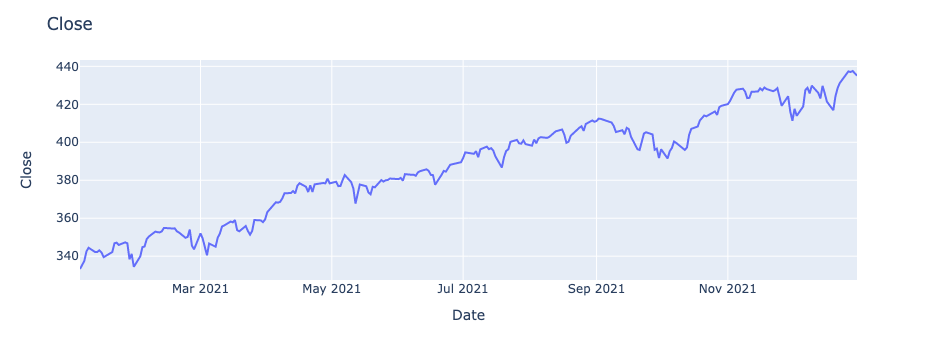

In [110]:
fig = px.line(prep, x="Date", y="Close")
fig.update_layout(
    title="VOO Close Value"
)
fig.show()

In [99]:
mas = []
temp = pd.DataFrame()
temp['date'] = prep['Date']
temp['value'] = prep['Close']
temp['name'] = 'Close'
mas.append(temp)
for i in [ma_short, ma_long]:
    temp = pd.DataFrame()
    temp['date'] = prep['Date']
    temp['value'] = prep['Close'].rolling(i).mean()
    temp['name'] = f'MA_{i}'
    mas.append(temp)
ma = pd.concat(mas, axis=0)

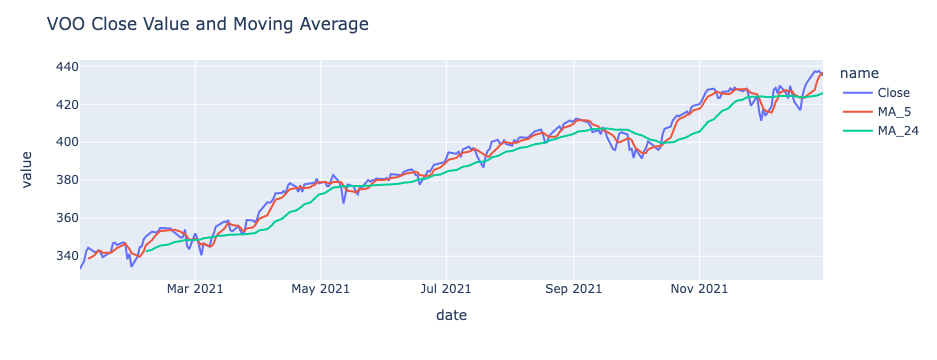

In [111]:
fig = px.line(ma, x="date", y="value", color='name')
fig.update_layout(
    title="VOO Close Value and Moving Average"
)
fig.show()

In [101]:
macd, macdsignal, macdhist = ta.MACD(prep.Close, fastperiod=mac_fastperiod, slowperiod=mac_slowperiod, signalperiod=mac_signalperiod)

In [102]:
# create dataframe for MACD
df1 = pd.DataFrame()
df1['date'] = prep['Date']
df1['value'] = macd
df1['mac'] = 'macd'
df2 = pd.DataFrame()
df2['date'] = prep['Date']
df2['value'] = macdsignal
df2['mac'] = 'macsignal'

In [103]:
# calc golden cross and dead cross
df3 = pd.DataFrame()
df3['date'] = prep['Date']
df3['macd'] = macd
df3['macdsignal'] = macdsignal
df3['is_macd_higher'] = df3.apply(lambda x: 1 if x.macd >= x.macdsignal else 0, axis=1)
df3['lag_is_macd_higher'] = df3.is_macd_higher.shift(1)

In [104]:
golden = df3.query('is_macd_higher == 1 and lag_is_macd_higher == 0').date.values
dead = df3.query('is_macd_higher == 0 and lag_is_macd_higher == 1').date.values

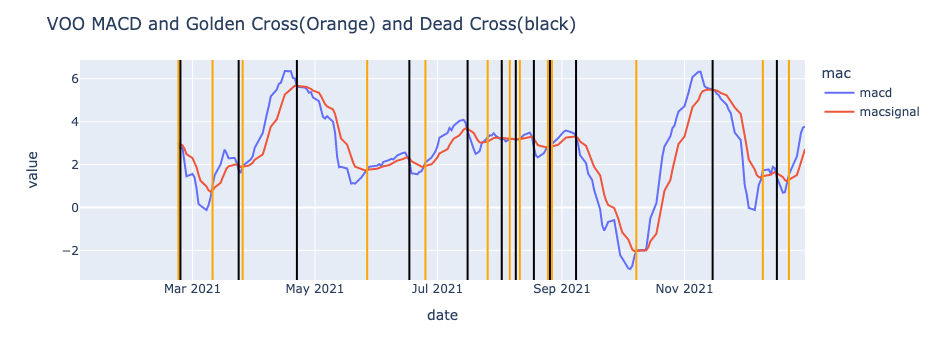

In [112]:
fig = px.line(pd.concat([df1, df2]), x="date", y="value", color='mac')
for g in golden:
    fig.add_vline(g, line_color="orange")
for d in dead:
    fig.add_vline(d, line_color="black")
fig.update_layout(
    title="VOO MACD and Golden Cross(Orange) and Dead Cross(black)"
)
fig.show()